In [33]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

def fetch_crypto_for_trading(symbols, period='1y'):
    """
    Simple function untuk fetch crypto data untuk trading strategies
    """
    print(f"Fetching crypto data untuk trading...")
    print(f"Symbols: {symbols}")
    print(f"Period: {period}")
    print("-" * 40)
    
    crypto_data = {}
    successful_fetches = []
    
    for symbol in symbols:
        try:
            print(f"Fetching {symbol}...")
            # Fetch data
            ticker = yf.Ticker(f"{symbol}-USD")
            data = ticker.history(period=period)
            
            if len(data) > 100: # Ensure enough data untuk grid trading
                crypto_data[symbol] = data
                successful_fetches.append(symbol)
                print(f"✅ {symbol}: {len(data)} days")
                print(f"   Range: {data.index[0].date()} to {data.index[-1].date()}")
                print(f"   Latest: ${data['Close'].iloc[-1]:.2f}")
            else:
                print(f"   {symbol}: Insufficient data ({len(data)} days)")

        except Exception as e:
            print(f"❌ {symbol}: Error - {str(e)}")

    print("-" * 40)
    print(f"✅ Successfully fetched {len(successful_fetches)} cryptos")
    return crypto_data

# Fetch data untuk grid trading strategies
trading_symbols = ['BTC', 'ETH', 'BNB', 'ADA', 'SOL']
raw_crypto_data = fetch_crypto_for_trading(trading_symbols, period='1y')

Fetching crypto data untuk trading...
Symbols: ['BTC', 'ETH', 'BNB', 'ADA', 'SOL']
Period: 1y
----------------------------------------
Fetching BTC...
✅ BTC: 366 days
   Range: 2024-10-21 to 2025-10-21
   Latest: $110173.97
Fetching ETH...
✅ ETH: 366 days
   Range: 2024-10-21 to 2025-10-21
   Latest: $3937.69
Fetching BNB...
✅ BNB: 366 days
   Range: 2024-10-21 to 2025-10-21
   Latest: $1088.17
Fetching ADA...
✅ ADA: 366 days
   Range: 2024-10-21 to 2025-10-21
   Latest: $0.66
Fetching SOL...
✅ SOL: 366 days
   Range: 2024-10-21 to 2025-10-21
   Latest: $189.15
----------------------------------------
✅ Successfully fetched 5 cryptos


In [34]:
def show_data_overview(crypto_data):
    """
    Quick overview of fetched data
    """
    print("\n\n📊 CRYPTO DATA OVERVIEW")
    print("=" * 50)

    for symbol, data in crypto_data.items():
        print(f"\n♦ {symbol} ({len(data)} Records)")
        print(f"  Date Range: {data.index[0].date()} to {data.index[-1].date()}")
        print(f"  Price Range: ${data['Low'].min():,.0f} - ${data['High'].max():,.0f}")
        print(f"  Current Price: ${data['Close'].iloc[-1]:,.2f}")

        # Check basic data quality
        missing_values = data.isnull().sum().sum()
        zero_volume = (data['Volume'] == 0).sum()

        if missing_values > 0:
            print(f"  ⚠️  Missing values: {missing_values}")
        if zero_volume > 0:
            print(f"  ⚠️  Zero volume days: {zero_volume}")
        
        if missing_values == 0 and zero_volume == 0:
            print(f"  ✅ Data quality: Good")

show_data_overview(raw_crypto_data)



📊 CRYPTO DATA OVERVIEW

♦ BTC (366 Records)
  Date Range: 2024-10-21 to 2025-10-21
  Price Range: $65,188 - $126,198
  Current Price: $110,173.97
  ✅ Data quality: Good

♦ ETH (366 Records)
  Date Range: 2024-10-21 to 2025-10-21
  Price Range: $1,387 - $4,954
  Current Price: $3,937.69
  ✅ Data quality: Good

♦ BNB (366 Records)
  Date Range: 2024-10-21 to 2025-10-21
  Price Range: $510 - $1,371
  Current Price: $1,088.17
  ✅ Data quality: Good

♦ ADA (366 Records)
  Date Range: 2024-10-21 to 2025-10-21
  Price Range: $0 - $1
  Current Price: $0.66
  ✅ Data quality: Good

♦ SOL (366 Records)
  Date Range: 2024-10-21 to 2025-10-21
  Price Range: $97 - $294
  Current Price: $189.15
  ✅ Data quality: Good


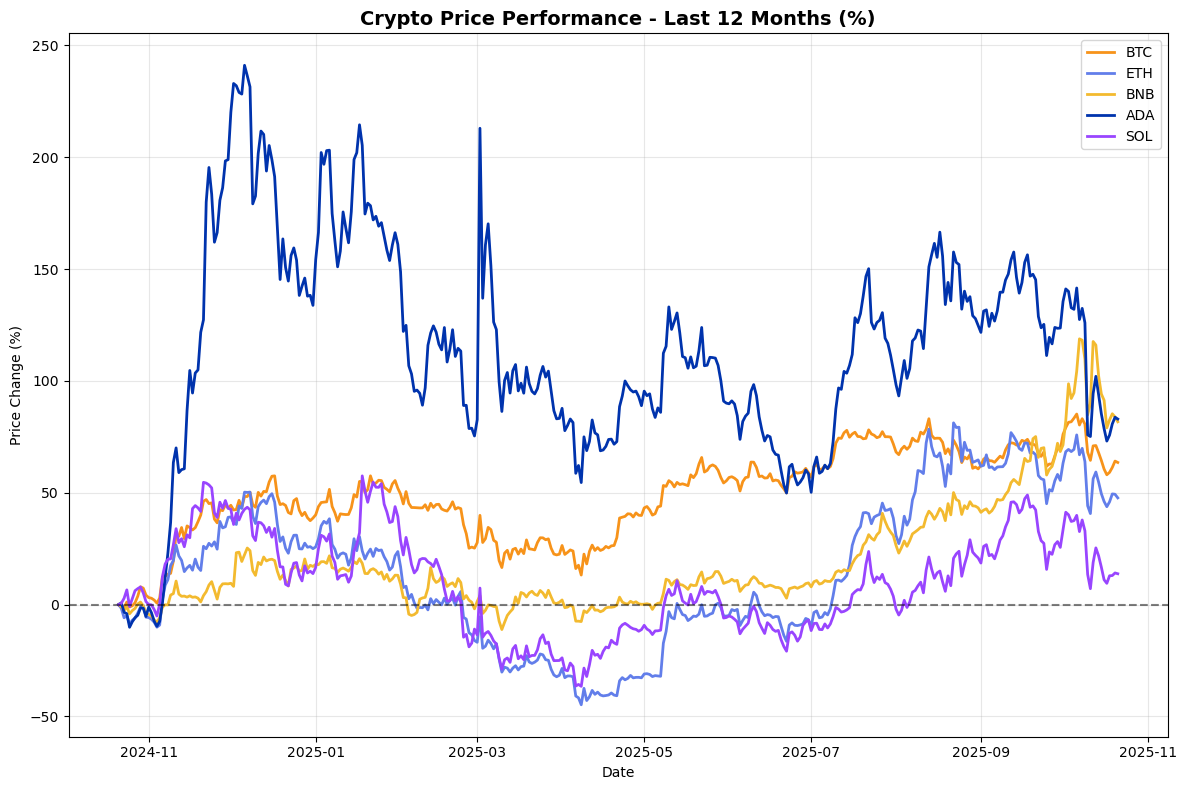

✅ 12-Month Performance Summary:
BTC: +63.5%
ETH: +47.7%
BNB: +81.7%
ADA: +83.0%
SOL: +13.8%


In [35]:
def plot_price_overview(crypto_data):
    """
    Simple price chart untuk semua cryptos
    """
    plt.figure(figsize=(12, 8))
    colors = ['#f7931a', '#627eea', '#f3ba2f', '#0033ad', '#9945ff']

    for i, (symbol, data) in enumerate(crypto_data.items()):
        # Normalize to percentage change
        normalized = (data['Close'] / data['Close'].iloc[0] - 1) * 100
        
        plt.plot(data.index, normalized,
                 label=f"{symbol}",
                 linewidth=2,
                 color=colors[i % len(colors)])

    plt.title('Crypto Price Performance - Last 12 Months (%)', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Price Change (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Print performance summary
    print("✅ 12-Month Performance Summary:")
    for symbol, data in crypto_data.items():
        perf = (data['Close'].iloc[-1] / data['Close'].iloc[0] - 1) * 100
        print(f"{symbol}: {perf:+.1f}%")

plot_price_overview(raw_crypto_data)

In [36]:
def clean_trading_data(data, symbol):
    """
    Clean data untuk trading strategies - keep it simple!
    """
    print(f"🧹 Cleaning {symbol} data...")
    original_length = len(data)
    cleaned = data.copy()

    # 1. Remove any rows dengan missing OHLC
    cleaned = cleaned.dropna(subset=['Open', 'High', 'Low', 'Close'])

    # 2. Fix basic OHLC inconsistencies
    # Ensure High >= max(Open, Close) and Low <= min(Open, Close)
    cleaned['High'] = np.maximum(cleaned['High'], 
                                 np.maximum(cleaned['Open'], cleaned['Close']))
    cleaned['Low'] = np.minimum(cleaned['Low'], 
                                np.minimum(cleaned['Open'], cleaned['Close']))

    # 3. Handle zero volume (replace dengan previous day)
    if 'Volume' in cleaned.columns:
        zero_vol_mask = cleaned['Volume'] <= 0
        if zero_vol_mask.sum() > 0:
            # Menggunakan ffill (forward fill) untuk mengisi nilai 0 dengan nilai volume hari sebelumnya
            cleaned['Volume'] = cleaned['Volume'].replace(0, method='ffill')
            print(f"   Fixed {zero_vol_mask.sum()} zero volume days")
            
    # 4. Remove extreme outliers (>75% change in one day - obvious errors)
    daily_returns = cleaned['Close'].pct_change().abs()
    extreme_mask = daily_returns > 0.75

    if extreme_mask.sum() > 0:
        print(f"   ⚠️  Found {extreme_mask.sum()} extreme outliers")
        # Replace dengan interpolated values instead of removing
        for idx in cleaned[extreme_mask].index:
            if idx != cleaned.index[0]:
                prev_price = cleaned['Close'].shift(1).loc[idx]
                if not pd.isna(prev_price):
                    # Gunakan harga penutupan hari sebelumnya sebagai pendekatan konservatif
                    cleaned.loc[idx, 'Close'] = prev_price
                    cleaned.loc[idx, 'Open'] = prev_price
                    cleaned.loc[idx, 'High'] = prev_price * 1.05 # Sedikit penyesuaian
                    cleaned.loc[idx, 'Low'] = prev_price * 0.95

    # 5. Sort by date (ensure chronological order)
    cleaned = cleaned.sort_index()
    
    print(f"   ✅ Cleaned: {original_length} -> {len(cleaned)} records")
    print(f"      Price range: ${cleaned['Low'].min():,.0f} - ${cleaned['High'].max():,.0f}")
    return cleaned


# Clean all crypto data
clean_crypto_data = {}
for symbol, data in raw_crypto_data.items():
    clean_crypto_data[symbol] = clean_trading_data(data, symbol)

print(f"\n✅ All data cleaned successfully!")

🧹 Cleaning BTC data...
   ✅ Cleaned: 366 -> 366 records
      Price range: $65,188 - $126,198
🧹 Cleaning ETH data...
   ✅ Cleaned: 366 -> 366 records
      Price range: $1,387 - $4,954
🧹 Cleaning BNB data...
   ✅ Cleaned: 366 -> 366 records
      Price range: $510 - $1,371
🧹 Cleaning ADA data...
   ✅ Cleaned: 366 -> 366 records
      Price range: $0 - $1
🧹 Cleaning SOL data...
   ✅ Cleaned: 366 -> 366 records
      Price range: $97 - $294

✅ All data cleaned successfully!


In [37]:
def quick_quality_check(crypto_data):
    """
    Quick quality check untuk trading data
    """
    print("\n\n🔍 QUALITY CHECK RESULTS")
    print("=" * 40)
    
    all_good = True
    
    for symbol, data in crypto_data.items():
        print(f"\nChecking {symbol}:")
        issues = []
        
        # Check for missing values
        if data.isnull().sum().sum() > 0:
            issues.append("Missing values")
            all_good = False
        
        # Check for zero prices
        if (data['Close'] <= 0).sum() > 0:
            issues.append("Zero prices")
            all_good = False
            
        # Check data length
        if len(data) < 200:
            issues.append("Insufficient data")
            all_good = False
            
        # Check date continuity (allow some gaps for weekends)
        date_gaps = data.index.to_series().diff().dt.days
        large_gaps = (date_gaps > 7).sum() # More than 1 week gap
        if large_gaps > 5: # allow some gaps
            issues.append(f"{large_gaps} large time gaps")
            all_good = False

        if issues:
            print(f"  ⚠️  Issues: {', '.join(issues)}")
        else:
            print(f"  ✅ Quality: Good ({len(data)} records)")
            
    print("=" * 40)
    if all_good:
        print("▶️  All data passed quality check!")
        print("✅ Ready untuk grid trading strategies!")
    else:
        print("⚠️ Some issues found - review data before trading")
        
    return all_good

# Run quality check
data_quality_ok = quick_quality_check(clean_crypto_data)



🔍 QUALITY CHECK RESULTS

Checking BTC:
  ✅ Quality: Good (366 records)

Checking ETH:
  ✅ Quality: Good (366 records)

Checking BNB:
  ✅ Quality: Good (366 records)

Checking ADA:
  ✅ Quality: Good (366 records)

Checking SOL:
  ✅ Quality: Good (366 records)
▶️  All data passed quality check!
✅ Ready untuk grid trading strategies!


In [38]:
def analyze_volatility_for_grid(crypto_data):
    """
    Analyze volatility - key untuk grid trading parameter setting
    """
    print("\n\n📈 VOLATILITY ANALYSIS FOR GRID TRADING")
    print("=" * 50)
    
    volatility_data = {}
    
    for symbol, data in crypto_data.items():
        # Calculate daily returns
        returns = data['Close'].pct_change().dropna()
        
        # Different volatility measures
        daily_vol = returns.std() * 100
        weekly_vol = returns.std() * np.sqrt(7) * 100
        monthly_vol = returns.std() * np.sqrt(30) * 100
        
        # Price range analysis
        avg_daily_range = ((data['High'] - data['Low']) / data['Close'] * 100).mean()
        
        volatility_data[symbol] = {
            'daily_vol': daily_vol,
            'weekly_vol': weekly_vol,
            'monthly_vol': monthly_vol,
            'avg_daily_range': avg_daily_range
        }
        
        print(f"\nAnalyzing {symbol}:")
        print(f"  Daily Volatility: {daily_vol:.2f}%")
        print(f"  Avg Daily Range: {avg_daily_range:.2f}%")
        print(f"  Monthly Volatility: {monthly_vol:.1f}%")

    print("=" * 50)
    print("💡 Grid Trading Insights:")
    
    # Sort by volatility untuk recommendations
    sorted_by_vol = sorted(volatility_data.items(), 
                           key=lambda x: x[1]['daily_vol'], reverse=True)
    
    print(f"  🔴 Highest Volatility: {sorted_by_vol[0][0]} ({sorted_by_vol[0][1]['daily_vol']:.1f}%)")
    print(f"  🟢 Lowest Volatility: {sorted_by_vol[-1][0]} ({sorted_by_vol[-1][1]['daily_vol']:.1f}%)")
    print(f"\n   Grid Spacing Suggestions:")
    
    for symbol, vol_data in volatility_data.items():
        # Rule of thumb: grid spacing is a fraction of the average daily range
        suggested_spacing = vol_data['avg_daily_range'] * 0.5 # Conservative
        print(f"   {symbol}: ~{suggested_spacing:.1f}% grid spacing")
        
    return volatility_data

volatility_analysis = analyze_volatility_for_grid(clean_crypto_data)



📈 VOLATILITY ANALYSIS FOR GRID TRADING

Analyzing BTC:
  Daily Volatility: 2.34%
  Avg Daily Range: 3.39%
  Monthly Volatility: 12.8%

Analyzing ETH:
  Daily Volatility: 4.01%
  Avg Daily Range: 5.68%
  Monthly Volatility: 22.0%

Analyzing BNB:
  Daily Volatility: 2.82%
  Avg Daily Range: 4.03%
  Monthly Volatility: 15.4%

Analyzing ADA:
  Daily Volatility: 6.25%
  Avg Daily Range: 7.41%
  Monthly Volatility: 34.2%

Analyzing SOL:
  Daily Volatility: 4.58%
  Avg Daily Range: 6.48%
  Monthly Volatility: 25.1%
💡 Grid Trading Insights:
  🔴 Highest Volatility: ADA (6.2%)
  🟢 Lowest Volatility: BTC (2.3%)

   Grid Spacing Suggestions:
   BTC: ~1.7% grid spacing
   ETH: ~2.8% grid spacing
   BNB: ~2.0% grid spacing
   ADA: ~3.7% grid spacing
   SOL: ~3.2% grid spacing


In [39]:
def create_trading_dataset(crypto_data):
    """
    Create standardized dataset untuk trading strategies
    """
    print("\n\n💾 Creating trading dataset...")
    
    # Create data directory
    os.makedirs('trading_data', exist_ok=True)
    
    trading_dataset = {}
    
    for symbol, data in crypto_data.items():
        # Add basic indicators yang akan digunakan untuk grid trading
        df = data.copy()
        
        # Simple Moving Averages
        df['SMA_20'] = df['Close'].rolling(20).mean()
        df['SMA_50'] = df['Close'].rolling(50).mean()
        
        # Daily Returns
        df['Daily_Return'] = df['Close'].pct_change()
        
        # Daily Range (important untuk grid spacing)
        df['Daily_Range_Pct'] = ((df['High'] - df['Low']) / df['Close']) * 100
        
        # Rolling volatility (20-day)
        # Menggunakan 252 karena ini standar untuk hari trading finansial (bukan 365)
        df['Volatility_20d'] = df['Daily_Return'].rolling(20).std() * np.sqrt(252) * 100

        # Clean column names
        df = df.round(4) # Round untuk cleaner data
        
        trading_dataset[symbol] = df
        
        # Save individual files
        filename = f"trading_data/{symbol}_trading_data.csv"
        df.to_csv(filename)
        print(f"   ✅ Saved ({symbol}): {filename}")

    # Create summary file dengan key metrics
    summary_data = []
    for symbol, data in trading_dataset.items():
        summary_data.append({
            'Symbol': symbol,
            'Records': len(data),
            'Start_Date': data.index[0].date(),
            'End_Date': data.index[-1].date(),
            'Latest_Price': data['Close'].iloc[-1],
            'Avg_Daily_Vol': data['Volatility_20d'].mean(),
            'Avg_Daily_Range': data['Daily_Range_Pct'].mean()
        })
        
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv('trading_data/dataset_summary.csv', index=False)
    print(f"✅ Saved summary: trading_data/dataset_summary.csv")

    return trading_dataset

trading_dataset = create_trading_dataset(clean_crypto_data)



💾 Creating trading dataset...
   ✅ Saved (BTC): trading_data/BTC_trading_data.csv
   ✅ Saved (ETH): trading_data/ETH_trading_data.csv
   ✅ Saved (BNB): trading_data/BNB_trading_data.csv
   ✅ Saved (ADA): trading_data/ADA_trading_data.csv
   ✅ Saved (SOL): trading_data/SOL_trading_data.csv
✅ Saved summary: trading_data/dataset_summary.csv


In [40]:
def load_crypto_trading_data(symbol, start_date=None, end_date=None):
    """
    Load crypto data untuk trading strategies
    """
    try:
        filename = f"trading_data/{symbol}_trading_data.csv"
        
        if not os.path.exists(filename):
            print(f"❌ Data file tidak ditemukan: {filename}")
            return None
            
        data = pd.read_csv(filename, index_col=0, parse_dates=True)
        
        # Filter by date range if provided
        if start_date:
            data = data[data.index >= start_date]
        if end_date:
            data = data[data.index <= end_date]
            
        print(f"✅ Loaded {symbol}: {len(data)} records")
        if start_date or end_date:
            print(f"   Date range: {data.index[0].date()} to {data.index[-1].date()}")
            
        return data

    except Exception as e:
        print(f"❌ Error loading {symbol}: {str(e)}")
        return None

def get_available_cryptos():
    """
    Get list of available crypto data
    """
    if not os.path.exists('trading_data'):
        return []
    
    files = [f for f in os.listdir('trading_data') if f.endswith('_trading_data.csv')]
    symbols = [f.replace('_trading_data.csv', '') for f in files]
    return symbols

# Demo: Test data loading
print("\n\n--- Demo Data Loading ---")
print("📖 Available crypto data:")
available_symbols = get_available_cryptos()
for symbol in available_symbols:
    print(f"  ✅ {symbol}")

# Test load function (SAMA PERSIS DENGAN VIDEO)
if 'BTC' in available_symbols:
    btc_test = load_crypto_trading_data('BTC', start_date='2024-01-01')
    
    if btc_test is not None:
        print(f"\nBTC Sample Data:")
        print(btc_test[['Close', 'Daily_Range_Pct', 'Volatility_20d']].tail())



--- Demo Data Loading ---
📖 Available crypto data:
  ✅ ETH
  ✅ BTC
  ✅ ADA
  ✅ BNB
  ✅ SOL
✅ Loaded BTC: 366 records
   Date range: 2024-10-21 to 2025-10-21

BTC Sample Data:
                                 Close  Daily_Range_Pct  Volatility_20d
Date                                                                   
2025-10-17 00:00:00+00:00  106467.7891           5.2949         41.0899
2025-10-18 00:00:00+00:00  107198.2656           1.0294         40.2818
2025-10-19 00:00:00+00:00  108666.7109           3.0655         39.8634
2025-10-20 00:00:00+00:00  110588.9297           3.8214         40.4843
2025-10-21 00:00:00+00:00  110173.9688           2.7316         37.3976
